# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    
    
```

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

**class_counts: (very uneven)**
1. chapati        862
1. nyamachoma     784
1. bhaji          632
1. ugali          628
1. mandazi        620
1. kachumbari     494
1. matoke         483
1. githeri        479
1. masalachips    438
1. sukumawiki     402
1. pilau          329
1. mukimo         212
1. kukuchoma      173

Name: class, dtype: int64, sum: 6536



In [3]:
%matplotlib inline

In [4]:
# Import neccesaary libraries
import os
import time
import collections
from dataclasses import dataclass

# third party library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

# Pytorch related
import torch
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.optim import SGD  
from torch.utils.tensorboard import SummaryWriter
from torchvision.io import read_image
from torchvision import transforms
from torchvision.models import resnet152, resnet18

In [5]:
# all the Transforms
# def resize_preprocess():
#     """Compulsory transforms image to same_size and center cropped (not changing to Tensor yet)"""
#     resize_preprocess = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#     ])
    
#     return resize_preprocess


def small_image_preprocess_transforms():
    """pre_process for KenyanFood13Testset holding original database(No need to hold big image)"""
    small_image_preprocess = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(112),
        transforms.ToTensor()
    ])
    
    return small_image_preprocess

### from here to below will change to Tensor
def image_preprocess_transforms():
    """pre_process for KenyanFood13Testset """
    image_preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    
    return image_preprocess



def train_preprocess():
    """resize_preprocess() + couple transformation to improve accuracy in training, ToTensor and Normalization"""
    transforms_train = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        # Somehow this doesn't work
        #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio = (0.33, 0.33), value= 0, inplace = False), 
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.RandomPosterize(bits=2),
        transforms.ToTensor(),
        transforms.Normalize(tc.mean, tc.std)        



    ])
    return transforms_train
    
def validation_preprocess():
    """ image_preprocess() + Normalization"""
    validation_train = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(tc.mean, tc.std)
    ])
    return validation_train



In [146]:
# Datasets Classes
class KenyanFood13Dataset(Dataset):
    """create KenyanFood Dataset from annotations_file and images"""
    def __init__(self, transform = None):
        self.img_labels = pd.read_csv(tc.annotation_file)
        self.img_dir = tc.img_dir
        # Make list of the classes list will give index (iterable) -> 13 classes
        self.classes = list(self.img_labels['class'].unique()) 
        # Make dictionary set of the classes 
        self.dict_classes = dict(enumerate(self.img_labels['class'].unique()))
        self.transform = transform
        
        # weigths of each class normalized (total = 1.0)
        def _inverse_ratio():
            """calculate inverse ratio of number of each classes for weighted sampler usage"""
            series = self.img_labels['class'].value_counts()
            total = series.sum()
            for index, _ in enumerate(series):
                series.iloc[index] = series.iloc[index]/total
            return series
        
       
        self.class_weights = 1/self.img_labels['class'].value_counts()

        
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index):
        """Return (image, target) after resizing and preprocessing 
        iloc[index, 0] will return ids (e.g.,14278962987112149800) of each row"""
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[index, 0])+".jpg")
        image = Image.open(img_path)
                
        # label is string so will return index (pytorch cannot make string to tensor)
        # iloc[index, 1] will return the class_name (e.g., githeri) for id in [index, 1] (e.g., 14278962987112149800)
        label_index = self.class2index(self.img_labels.iloc[index, 1])  # returns int

        if self.transform:
            image = self.transform(image)

        return image, label_index #image: Image or Tensor ,  label_index: int
    
    
    def class2index(self, class_name:str)-> int:
        """Returns the index of a given class."""
        return self.classes.index(class_name)
    
    
    def index2class(self, class_index:int)-> str:
        """Returns the class of a given index."""
        return self.classes[class_index]

    
class KenyanFood13SplitDataset(Dataset):
    """creates split train and validation subset from KenyanFood13Dataset based on indices"""
    def __init__(self, indices:np, transform = None):
        self.indices = indices
        self.transform = transform
        self.dataset = KenyanFood13Dataset()
        
    def __getitem__(self, index):
        image, label = self.dataset[self.indices[index]]
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def __len__(self):
        return len(self.indices)

    
class KenyanFood13Testset(Dataset):
    """Kenyan food test dataset, contains original KenanFood13Dataset for image2class and class2image methods"""
    def __init__(self, transform = image_preprocess_transforms()):
        self.img_dir = tc.img_dir
        self.test_labels = pd.read_csv(tc.test_csv_file)
        self.transform = transform
        # this is to use class2index() and class2index()
        self.base_dataset = KenyanFood13Dataset(small_image_preprocess_transforms())

    def __getitem__(self, index):
        """Retrieves one item from the dataset."""
        
        # get img path from test_labels. img_dir + id in csv file (per index) + ".jpg" 
        img = os.path.join(self.img_dir, str(self.test_labels.iloc[index, 0]) + '.jpg')
        
        image = Image.open(img)

        if self.transform:
            image = self.transform(image)

        return image
    
    def __len__(self):
        return len(self.test_labels)

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/pytorch-opencv-course-classification/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [81]:
# Settings and configurations
@dataclass
class SystemConfiguration:
    seed:int = 21
        
# Specifiy all the data needed in dataclass named TrainingConfiguration
@dataclass
class TrainingConfiguration:
    batch_size: int = 52
    epoch_count: int = 5
    init_learning_rate: float = 0.001
    log_interval: int = 5
    test_interval: int = 1
    data_root: str = "/kaggle/input/opencv-pytorch-dl-course-classification/"
    model_dir: str = '/kaggle/working/models/'
    log_dir: str = '/kaggle/working/logs'
    annotation_file: str = data_root + "train.csv"
    test_csv_file: str = data_root + "test.csv"
    img_dir: str = data_root + "images/images/"
    submission_csv: str = '/kaggle/working/submission.csv'
    num_workers: int = 2
    device: str = 'cuda'
    train_split: float = 0.8
    random_seed: int = 42
    model_name: str = "resnet152"
    lr: float =0.00001
    classes: tuple = ('githeri', 'ugali', 'kachumbari', 'matoke', 'sukumawiki', 'bhaji', 'mandazi', 'kukuchoma', 'nyamachoma', 'pilau', 'chapati', 'masalachips', 'mukimo')
    dataset_len: int = 6536
    #below is calculated from KenyanFood13 pictures
    #mean: torch.tensor = torch.tensor([0.5768, 0.4622, 0.3460])
    #std: torch.tensor = torch.tensor([0.2699, 0.2739, 0.2826])
    
    #below mean and standard are for Resnet18 https://pytorch.org/hub/pytorch_vision_resnet/
    mean: torch.tensor = torch.tensor([0.485, 0.456, 0.406])
    std: torch.tensor  = torch.tensor([0.229, 0.224, 0.225])
        
    tb_writer: SummaryWriter = SummaryWriter(log_dir)
    criterion: torch.nn.CrossEntropyLoss = torch.nn.CrossEntropyLoss()        

def setup_system(SystemConfiguration):
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.backends.cudnn_benchmark_enabled = True
        torch.backends.cudnn.deterministic = True
        
        
tc = TrainingConfiguration()
system_config = SystemConfiguration()
setup_system(system_config)


for path in [tc.log_dir, tc.model_dir]:
    if not os.path.exists(path):
        os.makedirs(path)


## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

In [8]:
def train(model, train_loader, optimizer) -> float:
    """train by model by given train_loader(and its datasets) and optimizer, return average loss and accuracy"""
    total_loss = 0.0
    total_acc = 0
    count = 0
    model.train()
    
    for inputs, labels in tqdm(train_loader):
        count += len(labels)
        # move to target device (GPU or CPU)
        inputs = inputs.to(tc.device)
        labels = labels.to(tc.device)
        
        # prediction
        outputs = model(inputs)
        # calculate loss
        loss = tc.criterion(outputs, labels)
        # initialize the gradients -> calucalte the gradients -> Update the gradients
        optimizer.zero_grad()     
        loss.backward()
        optimizer.step()
        
        # adds up loss pf number of batches
        total_loss += loss.item()
        # calculates accumulative average loss by dividing total loss by length of dataset predicted so far
        avg_loss = total_loss / count
        
        # get highest predicted value
        predicted = torch.max(outputs, axis=1)[1]
        # calculates accumulative average accuracy by dividing total loss by length of dataset predicted so far
        total_acc  += (predicted == labels).sum().item()
        avg_acc =  total_acc / count
        
    return avg_loss, avg_acc

In [9]:
def validate(model, validation_loader):
    """validate by model by given validation_loader(and its datasets) , return average loss"""
    total_loss = 0.0
    total_acc = 0
    count = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in tqdm(validation_loader):
            count += len(labels)
            # move to target device (GPU or CPU)
            inputs = inputs.to(tc.device)
            labels = labels.to(tc.device)
            
            # prediction
            outputs = model(inputs)
            # calculate loss
            loss = tc.criterion(outputs, labels)
            
            # adds up loss pf number of batches
            total_loss += loss.item()
            # calculates accumulative average loss by dividing total loss by length of dataset predicted so far
            avg_loss = total_loss / count
            
            # get highest predicted value
            predicted = torch.max(outputs, axis=1)[1]
            # calculate number of correct answer
            total_acc  += (predicted == labels).sum().item()
            # calculates accumulative average accuracy by dividing total loss by length of dataset predicted so far
            avg_acc =  total_acc / count
        
            
    return avg_loss, avg_acc
        

In [10]:
def predict(trained_model, prediction_loader) -> list:
    """prediction with model and test_loader, returns list of prediction result, assume to be used for inference ONLY"""  
    predictions = torch.tensor([]).to(tc.device)
    for inputs in prediction_loader:
        inputs = inputs.to(tc.device)
        outputs = trained_model(inputs)
        # get the predicted result by index number, each prediction will be done by tc.batch_size so predicted is array of batch_size
        predictions = torch.hstack((predictions, torch.max(outputs, axis=1)[1]))
        
    return predictions.tolist()


## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

In [11]:
# Resnet 18 (or 152) and change last layer output to 13
model = resnet152(pretrained = True)
# Change the last output to 13
fc_in_features = model.fc.in_features
model.fc = torch.nn.Linear(fc_in_features, (len(tc.classes)))
model = model.to(tc.device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

In [12]:
## util functions

def get_mean_std(dataset):
    """returns mean and standard deviation of dataset given, since this method will take long time, once calcuated, not been used"""
    # calculated mean: tensor([0.5768, 0.4622, 0.3460]), std:tensor([0.2699, 0.2739, 0.2826]):
    loader = DataLoader(dataset)
    
    batch_mean = torch.zeros(3) # tensor([0,0,0])
    batch_mean_sqrd = torch.zeros(3)
    
    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0,2,3))
        batch_mean_sqrd += (batch_data **2).mean(dim=(0,2,3))
        
    mean = batch_mean / len(loader)
    var = (batch_mean_sqrd) / len(loader) - (mean **2)
    
    std = var ** .5
    
    print("mean: {}, std:{}:".format(mean, std))
    return mean, std


def eval_loss(data_loader, device, model, criterion):
    """evaluate losses and can use this for visualize"""
    for images, labales in data_loader:
        break
        
    inputs = images.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    return loss

def evaluate_history(history):
    import matplotlib.pyplot as plt
    print("initial stats: Loss{:.5f}  Accuracy{:.5f}".format(history[0,3], history[0,4]))
    print("final stats: Loss{:.5f}  Accuracy{:.5f}".format(history[-1,3], history[-1,4]))
    
    num_epochs = len(history)
    unit = num_epochs/10
    
    # Display learning curve (Loss)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='train')
    plt.plot(history[:,0], history[:,3], 'k', label='validation')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('# of iteration')
    plt.ylabel('loss')
    plt.title('learning curve (Loss)')
    plt.legend()
    plt.show()

    # Display learning curve (Accuracy)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='train')
    plt.plot(history[:,0], history[:,4], 'k', label='validation')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('# of iteration')
    plt.ylabel('loss')
    plt.title('learning curve (Accuracy')
    plt.legend()
    plt.show()


# model save and load functions
def save_model(model, device):
    if not os.path.exists(tc.model_dir):
        os.makedirs(tc.model_dir)
    
    model_path = os.path.join(tc.model_dir, tc.model_name)
    
    if device == "cuda":
        model.to("cpu")
    
    torch.save(model.state_dict(), model_path + "best_model.pt")
    
    if device == "cuda":
        model.to("cuda")
    
    return

def load_model(model):
    
    model_path = os.path.join(tc.model_dir, tc.model_name)
    model.load_state_dict(torch.load(model_path + 'best_model.pt'))
    
    return model

In [13]:
import torch
b = torch.tensor([1,3,2,3,4,4,4,1,1,1,1,1,1])
class_ids, class_counts = torch.unique(b, return_counts=True)
print(f"class_ids:{class_ids}")
print(f"class_counts:{class_counts}")

class_ids:tensor([1, 2, 3, 4])
class_counts:tensor([7, 1, 2, 3])


In [30]:
kenyan_dataset = KenyanFood13Dataset(transform = image_preprocess_transforms()) 
data_loader = DataLoader(kenyan_dataset, batch_size = tc.batch_size, shuffle = False)
print(kenyan_dataset.dict_classes)

* id: 0 'githeri': 479,
* id: 1 'ugali': 628,
* id: 2 'kachumbari': 494,
* id: 3 'matoke': 483,
* id: 4 'sukumawiki': 402,
* id: 5 'bhaji': 632,
* id: 6 'mandazi': 620,
* id: 7 'kukuchoma': 173,
* id: 8 'nyamachoma': 784,
* id: 9 'pilau': 329,
* id:10 'chapati': 862,
* id:11 'masalachips': 438,
* id:13 'mukimo': 212

In [134]:
dict_classes = {1:"Hello", 2:"kuni"}
list(range(len(dict_classes)))

[0, 1]

In [178]:
def visualize_batch_data(dataloader, with_visual_chart = True , with_class_string = True) -> dict:
    """visualize what class is in the batch to visually see the equalness of the samples"""
    #{0: 'githeri', 1: 'ugali', 2: 'kachumbari', 3: 'matoke', 4: 'sukumawiki', 5: 'bhaji', 6: 'mandazi', 7: 'kukuchoma', 8: 'nyamachoma', 9: 'pilau', 10: 'chapati', 11: 'masalachips', 12: 'mukimo'}
    # total_number_appeared: Counter({10: 862, 8: 784, 5: 632, 1: 628, 6: 620, 2: 494, 3: 483, 0: 479, 11: 438, 4: 402, 9: 329, 12: 212, 7: 173})
    total_num_images = len(data_loader.dataset)
    total_number_appeared = collections.Counter()
    number_appeared_per_batch = []
    dict_classes = data_loader.dataset.dict_classes
    
    for index, (_, label_index) in enumerate(data_loader): # don't use image
        class_ids, class_counts = torch.unique(label_index, return_counts=True) # return in torch.tensor
        number_appeared = collections.Counter(label_index.tolist())
        print(f"number_appeared:{number_appeared}")
        # add zero for sample which was not picked, and add that label_index:0 to Counter
        print(len(dict_classes))
        for i in range(len(dict_classes)):

            number_appeared.setdefault(i,0)
            print(f"number_appeared_after_setdefault:{number_appeared}")
        # for total count
#         print(f"number_appeared:{number_appeared}")
        total_number_appeared += number_appeared

            
        # sort based on keys (label_index) and cast to dict for visualization
        dict_number_appeared = dict(sorted(number_appeared.items()))
        #print(f"dict_number_appeared:{dict_number_appeared}")
        number_appeared_per_batch.append(dict_number_appeared)
        
    if with_visual_chart:
        """create bar graph for all batches which class had samples"""
        fig, axes = plt.subplots(int(tc.batch_size/4), 4 , figsize = (20, 20))
        for i in range(int(tc.batch_size/4)):
            for j in range(4):
                axes[i][j].bar(number_appeared_per_batch[int(j+(i*4))].keys(), list(number_appeared_per_batch[int(j+(i*4))].values()))
                if with_class_string:
                    axes[i][j].set_xticks(list(range(len(dict_classes))))
                    axes[i][j].set_xticklabels(list(dict_classes.values()))
                else:
                    axes[i][j].set_xticks(list(range(len(dict_classes))))
                    axes[i][j].set_xticklabels(list(dict_classes.keys()))
#     if with_visual_chart:
#         plt.figure(figsize =(20,3))
#         for i in range(len(data_loader.dataset.dict_classes)):
#             number_appeared.setdefault(i,0)
#         number_appeared = dict(sorted(number_appeared.items()))
#         print(number_appeared)
#         plt.bar(list(number_appeared.keys()), list(number_appeared.values()), tick_label=list(data_loader.dataset.dict_classes.values()))
#         plt.title(f'Batch:{index}')
#         plt.show()

#     if with_visual_chart:
#         plt.figure(figsize = (20, 10))
#         plt.bar(list(total_number_appeared.keys()), list(total_number_appeared.values()),tick_label=list(data_loader.dataset.dict_classes.values()))
#         plt.show()
    
    # return dict type, key=class name, value=how many times appeared
    if with_class_string:
        return {data_loader.dataset.index2class(key):value for key, value in total_number_appeared.items()}
    
    # return dict type, key=class_id, value=how many times appeared
    return dict(total_number_appeared)


In [157]:
from torch.utils.data.sampler import BatchSampler

class BalancedBatchSampler(BatchSampler):
    
    
    def __init__(self, dataset, n_classes, n_samples):
        loader = DataLoader(dataset)
        # keep ALL the label as list
        self.labels_list = []
        for _, label in loader:
            self.labels_list.append(label)
        # and keep it as Tensor
        self.labels = torch.LongTensor(self.labels_list)
        
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes
        
    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size

In [163]:
print(len(kenyan_dataset.classes))
print(len(kenyan_dataset.img_labels))
print(len(kenyan_dataset.img_labels)/len(kenyan_dataset.classes))

13
6536
502.7692307692308


In [179]:
from torch.utils.data import WeightedRandomSampler
kenyan_dataset = KenyanFood13Dataset(transform = image_preprocess_transforms()) 
weight_sampler = WeightedRandomSampler(weights=kenyan_dataset.class_weights, num_samples=len(kenyan_dataset), replacement=True)
#balanced_batch_sampler = BalancedBatchSampler(kenyan_dataset, len(kenyan_dataset.classes), len(kenyan_dataset.img_labels)/len(kenyan_dataset.classes))
data_loader = DataLoader(kenyan_dataset, sampler = weight_sampler, batch_size = tc.batch_size, shuffle = False)
visualize_batch_data(data_loader, with_class_string = False)

number_appeared:Counter({4: 3, 9: 1, 1: 1, 20: 1, 7: 1, 3: 1})
13
number_appeared_after_setdefault:Counter({4: 3, 9: 1, 1: 1, 20: 1, 7: 1, 3: 1, 0: 0})
number_appeared_after_setdefault:Counter({4: 3, 9: 1, 1: 1, 20: 1, 7: 1, 3: 1, 0: 0})
number_appeared_after_setdefault:Counter({4: 3, 9: 1, 1: 1, 20: 1, 7: 1, 3: 1, 0: 0, 2: 0})
number_appeared_after_setdefault:Counter({4: 3, 9: 1, 1: 1, 20: 1, 7: 1, 3: 1, 0: 0, 2: 0})
number_appeared_after_setdefault:Counter({4: 3, 9: 1, 1: 1, 20: 1, 7: 1, 3: 1, 0: 0, 2: 0})
number_appeared_after_setdefault:Counter({4: 3, 9: 1, 1: 1, 20: 1, 7: 1, 3: 1, 0: 0, 2: 0, 5: 0})
number_appeared_after_setdefault:Counter({4: 3, 9: 1, 1: 1, 20: 1, 7: 1, 3: 1, 0: 0, 2: 0, 5: 0, 6: 0})
number_appeared_after_setdefault:Counter({4: 3, 9: 1, 1: 1, 20: 1, 7: 1, 3: 1, 0: 0, 2: 0, 5: 0, 6: 0})
number_appeared_after_setdefault:Counter({4: 3, 9: 1, 1: 1, 20: 1, 7: 1, 3: 1, 0: 0, 2: 0, 5: 0, 6: 0, 8: 0})
number_appeared_after_setdefault:Counter({4: 3, 9: 1, 1: 1, 20: 1, 7: 

KeyboardInterrupt: 

In [ ]:
kenyan_dataset = KenyanFood13Dataset(transform = image_preprocess_transforms()) 
data_loader = DataLoader(kenyan_dataset, batch_size = tc.batch_size, shuffle = False)
visualize_batch_data(data_loader, with_class_string = False)

In [148]:
kenyan_dataset = KenyanFood13Dataset(transform = image_preprocess_transforms()) 
print(kenyan_dataset.class_weights)

chapati        0.001160
nyamachoma     0.001276
bhaji          0.001582
ugali          0.001592
mandazi        0.001613
kachumbari     0.002024
matoke         0.002070
githeri        0.002088
masalachips    0.002283
sukumawiki     0.002488
pilau          0.003040
mukimo         0.004717
kukuchoma      0.005780
Name: class, dtype: float64


{2: 306, 5: 896, 3: 328, 4: 1634, 1: 912, 6: 438, 0: 549, 8: 997, 7: 476}

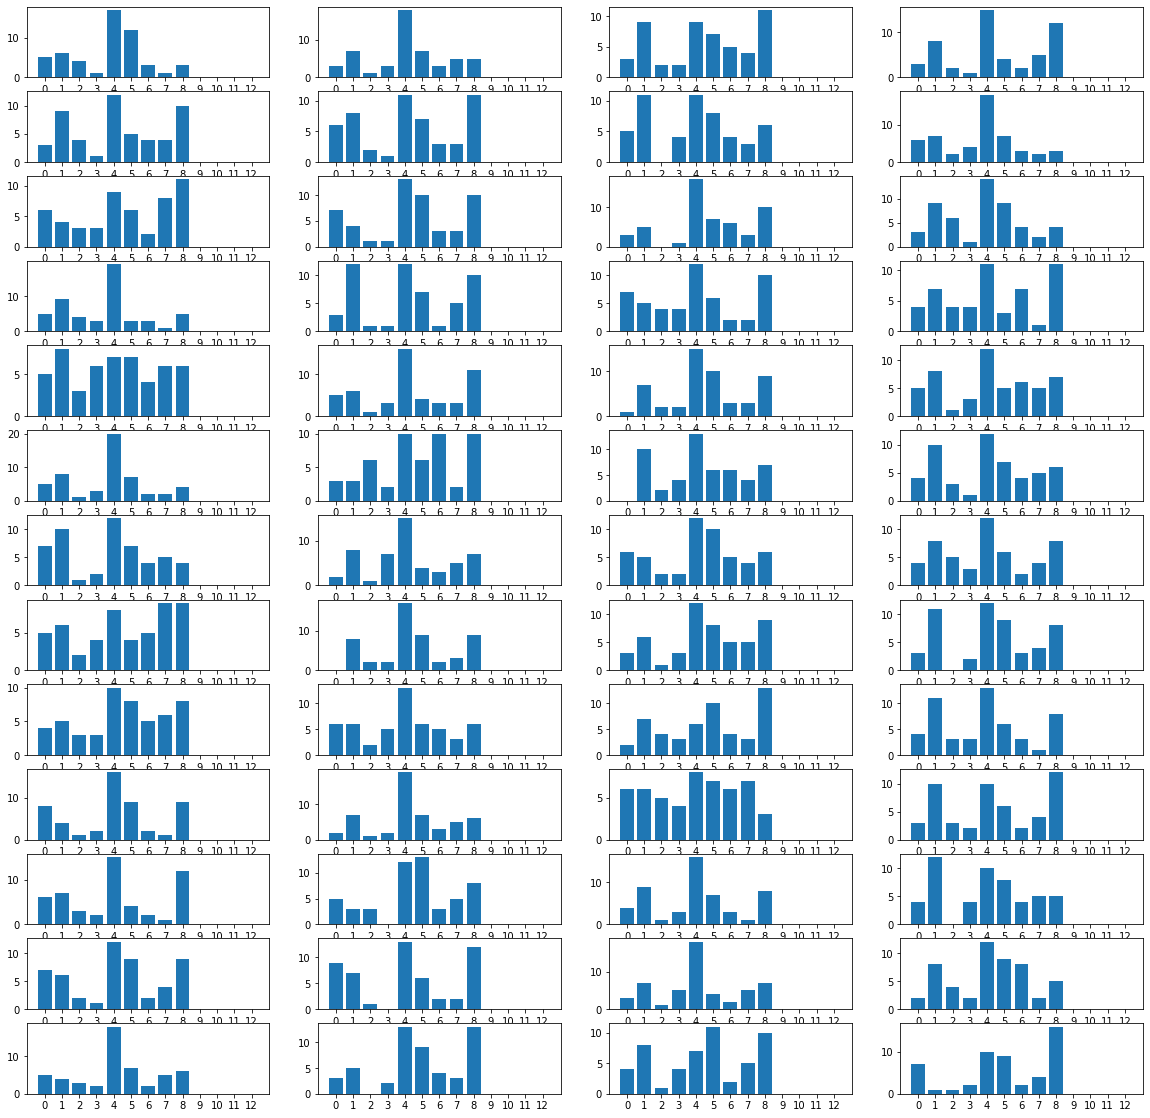

In [147]:
from torch.utils.data import WeightedRandomSampler
kenyan_dataset = KenyanFood13Dataset(transform = image_preprocess_transforms()) 
weight_sampler = WeightedRandomSampler(weights=kenyan_dataset.class_weights, num_samples=len(kenyan_dataset), replacement=True)
data_loader = DataLoader(kenyan_dataset, sampler = weight_sampler, batch_size = tc.batch_size, shuffle = False)
visualize_batch_data(data_loader, with_class_string = False)

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [ ]:
kenyan_dataset = KenyanFood13Dataset(transform = image_preprocess_transforms()) 
kenyan_dataset.classes
#kenyan_dataset.dict_classes

KenyanFood13Datase

In [ ]:
kenyan_dataset = KenyanFood13Dataset(transform = image_preprocess_transforms()) 
train_loader = DataLoader(kenyan_dataset, batch_size = tc.batch_size, shuffle = False)

for i, (imageTensor, label_index) in enumerate(train_loader):
    print(label_index)
    class_list = [kenyan_dataset.index2class(label_index[i]) for i in label_index]
    print(class_list)
    #print(type(batch[1]))
    if i == 1:
        break

for i, (imageTensor, label_index) in enumerate(train_loader):
    print(label_index)
    class_list = [kenyan_dataset.index2class(label_index[i]) for i in label_index]
    print(class_list)
    #print(type(batch[1]))
    if i == 1:
        break
        

for i, batch in enumerate(train_loader):
    print(label_index[1])
    #class_list = [kenyan_dataset.index2class(label_index[i]) for i in label_index]
    #print(class_list)
    #print(type(batch[1]))
    if i == 1:
        break

In [ ]:
# split dataset into train & validation dataset based on split ratio
kenyan_dataset = KenyanFood13Dataset() 
train_size = int(len(kenyan_dataset) * tc.train_split)
indices = np.arange(len(kenyan_dataset))
train_dataset = KenyanFood13SplitDataset(indices[:train_size], train_preprocess())
validation_dataset = KenyanFood13SplitDataset(indices[train_size:], validation_preprocess())

# create train & validation loader
train_sampler = WeightedRandomSampler(weights= kenyan_dataset.weights, num_samples=len(train_dataset), replacement=True)
train_loader = DataLoader(train_dataset, sampler= train_sampler, batch_size = tc.batch_size, shuffle = False)
validation_sampler = WeightedRandomSampler(weights= kenyan_dataset.weights, num_samples=len(validation_dataset), replacement=True)
validation_loader = DataLoader(validation_dataset, sampler= validation_sampler,batch_size = tc.batch_size, shuffle = False)

# create optimizer
optimizer = SGD(model.parameters(), lr=tc.lr, momentum = 0.9)


In [ ]:
kenyan_dataset = KenyanFood13Dataset(transform = image_preprocess_transforms())
train_loader = DataLoader(kenyan_dataset, batch_size = tc.batch_size, shuffle=False)



In [ ]:
data_frame = pd.read_csv(tc.annotation_file)
class_counts = data_frame['class'].value_counts()
class_weights = 1/(class_counts * class_weights.sum())
#total = series.sum()
print(f'class_counts: \n {class_counts}, sum: {class_counts.sum()}')
print(f'class_weights: \n {class_weights}, sum: {class_weights.sum()}')
    
# for index, value in enumerate(series):
#     series.iloc[index] = series.iloc[index]/total

# print(f'series: \n{series}')
# print(f'series sum:{series.sum()}')

# sample_weights = [1/series.values for i in series]
# print(sample_weights)
#print(class_counts.iat[0])

# for i in class_counts:
#     print(i)
# samples_weights =  [1/(class_counts[i] * class_weights.sum()) for i in class_counts]

In [ ]:
best_val_loss = np.Inf
history = np.zeros((0,6))
for epoch in range(tc.epoch_count):
    # time one cycle of train and validate
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer)
    val_loss, val_acc = validate(model, validation_loader)
    elapsed_time = time.time() - start_time
    
    # save the weight when the loss gets smaller than last one
    if val_loss < best_val_loss:
        save_model(model, tc.device)
        print("WEIGHTS-ARE-SAVED")
        best_val_loss = val_loss
        
    print(f"Epoch{epoch+1}/{tc.epoch_count}, loss:{train_loss:.5f}, acc:{train_acc:.5f}, val_loss:{val_loss:.5f}, val_acc:{val_acc:.5f}, elapsed_time:{elapsed_time:.5f}")
    # store 0:epoch, 1:avg_train_loss, 2: avg_train_acc, 3: avg_val_loss, 4: avg_val_acc, 5: elapsed_time
    item = np.array([epoch+1, train_loss, train_acc, val_loss, val_acc, elapsed_time])
    # store history for matplotlib visualization
    history = np.vstack((history, item))

    # For tensorboard
    tc.tb_writer.add_scalar('Loss/Train within {}/{}'.format(epoch+1,tc.epoch_count), train_loss, epoch+1)
    tc.tb_writer.add_scalar('Accuracy/Train within {}/{}'.format(epoch+1,tc.epoch_count), train_acc, epoch+1)
    tc.tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch+1)

In [ ]:
# Now do the inference and get submission.csv file
test_dataset = KenyanFood13Testset()
test_loader = DataLoader(test_dataset, batch_size = tc.batch_size, shuffle = False)

# prediction
predicted_result = predict(model, test_loader).tolist()
#print("predicted_result len:{}".format(len(predicted_result)))
classifications = []

#change predicted index to class_names
for index in range(len(predicted_result)):
    predicted_result_class = test_dataset.base_dataset.index2class(int(predicted_result[index]))
    classifications.append(predicted_result_class)

# put it to csv file
classes = pd.DataFrame(classifications, columns = ["class"])
result = test_dataset.test_labels.join(classes)
result.to_csv(tc.submission_csv, index=False, header = True)

In [ ]:
def fit(model, optimizer, train_loader, validation_loader, history):
    """works like tensorflow fits. epoch_count, optimizer and criterion(e.g., CrossEntorpyLoss) from training config"""
    
    #from tqdm.notebook import tqdm
    
    base_epochs = len(history)
    
    for epoch in range(base_epochs, tc.epoch_count + base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        best_valid_loss = np.Inf
        
        # training Phase
        model.train()
        count = 0
        
        t_begin = time.time()
        for inputs, labels in train_loader:
            
            count += len(labels)
            inputs = inputs.to(tc.device)
            labels = labels.to(tc.device)
            
            # initialize the gradients
            optimizer.zero_grad()
            # predict
            outputs = model(inputs)
            # calculate loss
            loss = tc.criterion(outputs, labels)
            train_loss += loss.item()
            
            #calucalte the graidents
            loss.backward()
            #update parameter
            optimizer.step()
            
            # get highest predicted value
            predicted = torch.max(outputs, axis=1)[1]
            # calculate number of correct answer
            train_acc  += (predicted == labels).sum().item()
            
            #calculate the average loss and accuracy in the batch
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count
            
        #evaluation phase
        model.eval()
        count = 0
        
        for inputs, labels in validation_loader:
            count += len(labels)
            inputs = inputs.to(tc.device)
            labels = labels.to(tc.device)
            
            # calculate the prediction
            outputs = model(inputs)
            
            # calculate the loss
            loss = tc.criterion(outputs, labels)
            val_loss += loss.item()
            
            if val_loss < best_valid_loss:
                torch.save(model.state_dict(), "best_model.pt")
                print("WEIGHTS-ARE-SAVED")
                best_valid_loss = val_loss
                
            # get highest predicted value
            predicted = torch.max(outputs, axis=1)[1]
            # calculate number of correct answer
            val_acc += (predicted == labels).sum().item()
            
            #calculate the average loss and accuracy in the batch
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
            
            
        elapsed_time = time.time() - t_begin
        # print out
        print("Epoch{}/{},  loss:{:.5f}, acc:{:.5f}, val_loss:{:.5f}, val_acc:{:.5f}, elapsed_time:{:.5f}".format(
            epoch+1,tc.epoch_count+base_epochs, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc, elapsed_time
        ))
        # store 0:epoch, 1:avg_train_loss, 2: avg_train_acc, 3: avg_val_loss, 4: avg_val_acc, 5: elapsed_time
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc, elapsed_time])
        history = np.vstack((history, item))
        
        # For tensorboard
        tc.tb_writer.add_scalar('Loss/Train within {}/{}'.format(epoch+1,tc.epoch_count+base_epochs), avg_train_loss, epoch+1)
        tc.tb_writer.add_scalar('Accuracy/Train within {}/{}'.format(epoch+1,tc.epoch_count+base_epochs), avg_train_acc, epoch+1)
        tc.tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch+1)

        
    return history

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = tc.batch_size, shuffle = True)
validation_loader = DataLoader(validation_dataset, batch_size = tc.batch_size, shuffle = False)
history = np.zeros((0,6)) # history to record 0: num of iteration, 1:training_loss, 2:trainin_acc, 3:val_loss, 4:val_acc 5:elapsed time
optimizer = SGD(model.parameters(), lr=tc.lr, momentum = 0.9)
history = fit(model, optimizer, train_loader, validation_loader, history)

## <font style="color:green">8. TensorBoard Dev Scalars Log Link [5 Points]</font>

**Share your TensorBoard scalars logs link here You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


For example, [Find Project2 logs here](https://tensorboard.dev/experiment/kMJ4YU0wSNG0IkjrluQ5Dg/#scalars).

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score , points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**